# Preprocessing

In [1]:
import pandas
import konlpy # Korean NLP library
import gensim # 
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from konlpy.tag import Mecab # 
from collections import Counter # 
from gensim.models.keyedvectors import Word2VecKeyedVectors # 
from tensorflow.keras.callbacks import EarlyStopping # 
from tensorflow.keras.initializers import Constant # 

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# Tokenization

In [3]:
# tokenizing Korean
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # word to index dict
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# index to word dict
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# add padding upto the length of the longest sentence
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, value=word_to_index['<PAD>'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, value=word_to_index['<PAD>'])

# Text classification models

### Common parameters

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

epochs=50

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)

### Embedding layer spec

In [8]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
output = embedding(raw_inputs)
print(output) # shape=(146182, 41, 100) = (Num of sentences, length of a sentence, word_vector dimension)

tf.Tensor(
[[[-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  [-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  [-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  ...
  [ 0.0460047  -0.04663639  0.0390445  ...  0.02758088  0.01457585
    0.00058652]
  [ 0.0354945  -0.01954355  0.00528178 ...  0.00811033 -0.00323573
    0.0121615 ]
  [ 0.04644456  0.04799997 -0.02281785 ... -0.01636813  0.0159363
    0.0170668 ]]

 [[-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  [-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  [-0.01463432 -0.04229749 -0.00869026 ...  0.0140558  -0.03970474
   -0.04543816]
  ...
  [ 0.03794048 -0.01540172 -0.04370211 ... -0.00403328  0.02390778
    0.00697532]
  [ 0.04733315  0.04229139  0.03023238 ...  0.00203298 -0.0476614
   -0.0083069 ]
  [-0.02884216  0.033977   -0.01363321 ... -0.03203841  0.032402

## RNN

In [9]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 5s 10ms/step - loss: 0.4608 - accuracy: 0.7916 - val_loss: 0.3555 - val_accuracy: 0.8470
Epoch 2/50
229/229 [==============================] - 2s 8ms/step - loss: 0.3614 - accuracy: 0.8577 - val_loss: 0.3425 - val_accuracy: 0.8509
Epoch 3/50
229/229 [==============================] - 2s 8ms/step - loss: 0.3332 - accuracy: 0.8719 - val_loss: 0.3337 - val_accuracy: 0.8544
Epoch 4/50
229/229 [==============================] - 2s 8ms/step - loss: 0.3058 - accuracy: 0.8829 - val_loss: 0.3369 - val_accuracy: 0.8566
Epoch 5/50
229/229 [==============================] - 2s 8ms/step - loss: 0.2816 - accuracy: 0.8923 - val_loss: 0.3422 - val_accuracy: 0.8572
Epoch 6/50
229/229 [==============================] - 2s 8ms/step - loss: 0.2611 - accuracy: 0.9009 - val_loss: 0.3718 - val_accuracy: 0.8572
Epoch 7/50
229/229 [==============================] - 2s 8ms/step - loss: 0.2419 - accuracy: 0.9088 - val_loss: 0.3732 - val_accuracy: 0.8545


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


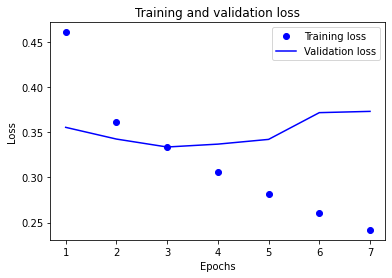

In [11]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

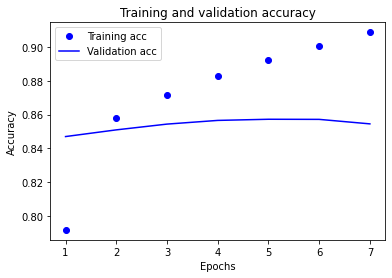

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 3s - loss: 0.3809 - accuracy: 0.8512


In [14]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [15]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.03295853, -0.05622855, -0.00556816, -0.06033933,  0.02879117,
       -0.04032219,  0.01385181, -0.05402616, -0.01275893,  0.02742808,
        0.01437925, -0.04816248, -0.04788369, -0.02769068,  0.00877775,
       -0.04664335, -0.05092414, -0.01511727,  0.05432827, -0.04963398,
       -0.04031419,  0.0202505 ,  0.04034482, -0.00745313,  0.0009485 ,
        0.02777333, -0.01580752, -0.10493282, -0.00377277, -0.05179713,
        0.06162333,  0.01606811, -0.03836405, -0.02905876, -0.04303792,
       -0.03033148, -0.00348624,  0.01850073, -0.04018797,  0.01978102,
       -0.00747245, -0.04744826, -0.03066888, -0.00334933,  0.02841861,
       -0.02381687, -0.00533727,  0.00548761, -0.01869498, -0.03644978,
       -0.02875089, -0.00588101,  0.03073625,  0.03394002,  0.03015404,
        0.02982683,  0.00845572, -0.01058838, -0.13607456, -0.04660797,
       -0.04952819, -0.0053462 ,  0.03129419, -0.01797702, -0.02087525,
        0.02605818,  0.00411258,  0.00769905,  0.02692822,  0.02

In [16]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

[('점', 0.5687216520309448), ('~~~!!!', 0.55588698387146), ('고뇌', 0.5385057926177979), ('뜸', 0.522944450378418), ('준다', 0.5218635201454163), ('...!', 0.5083067417144775), ('루', 0.5062141418457031), ('십니까', 0.5053071975708008), ('..??', 0.5021652579307556), ('남여', 0.501599907875061)]
[('민아', 0.3747355043888092), ('주연', 0.3602420389652252), ('못한', 0.3509407639503479), ('하루', 0.3395406901836395), ('을수록', 0.3213615119457245), ('의심', 0.3095138669013977), ('적시', 0.3051416277885437), ('김대중', 0.3015936613082886), ('데이즈', 0.2965576648712158), ('심히', 0.29525619745254517)]


In [25]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy'

In [ ]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

## 1-D CNN

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

In [ ]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

In [ ]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [ ]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

In [ ]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

### GlobalMaxPooling1D

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

In [ ]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

In [ ]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [ ]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

In [ ]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

# 회고

1회차
- 이번 프로젝트를 진행하며 3가지 방식으로 모델을 구축하였다.
    - RNN, 1-D CNN, 그리고 Globalmaxpooling 1D
- 처음에는 데이터 전처리 흐름이 잘 이해하기 힘들어서 여러번 노드를 보며 진행하였다.
    - IMDB의 데이터셋은 인코딩부터 word_to_index까지 다 이미 모듈이 있어서 다운을 받음으로 해결이 되었지만, Naver Sentiment Movie Corpus (NSMC)는 전혀 가공되지 않은 파일이어서 전처리 과정이 힘들었다.
- 시각화를 해본 결과, loss가 0.6 이하로 내려가지 않았고 accuracy도 50% 이상으로 올라가지 않았다

2회차
- 1회차 때 모델 학습결과가 크게 바뀌지 않는것에 의문이 들었고, 자세히 살펴본 결과 단어사전의 크기를 10으로 두었다는 것을 알게됐다.
- 또한 벡터 차원의 수도 4로 둔것을 찾아냈다.
- 단어사전 크기를 10000으로 그리고 벡터 차원의 수는 16으로 바꿔주니 loss값과 accuracy값이 올라가는 것을 확인할 수 있었다.
- 다만 val_accuracy가 기대치에 못 미치는 경향을 보였다.
- 그 이유가 그래프에서 볼 수 있듯이 학습을 하면 할수록 overfitting 되는 상황이 발생하기 때문이었다.
- epoch을 20으로 할 때나 50으로 할 때 비슷한 경향을 보였다.

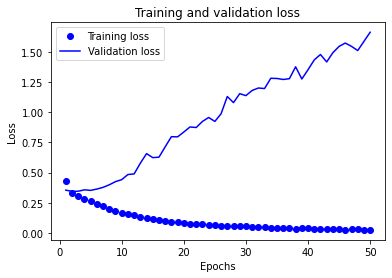

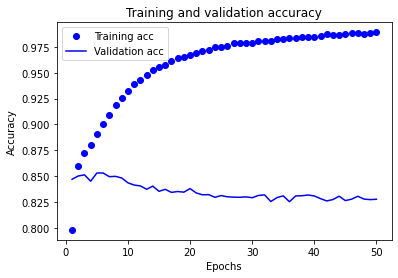

- 과적합을 방지하기 위해 early stopping을 추가해 주었고, model blueprint에 dropout도 추가해 주었고, 기대치에 맞는 정확도를 보였다.
- 정확도는 맞췄지만, 단어 '영화'와 '나'의 유사단어들을 보니 비슷한 느낌을 주는 단어들이 나오지 않았다.

3회차
- 단어의 유사도를 맞추기 위해 `word2vec_ko.model`를 사용했다.
    - `FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy'` 에러가 났다
    - 파일이 없다는 에러라는 걸 알았지만, `word2vec_ko.model`모델을 돌리면 `.wv` `wv.vectors.npy`등등 나오는 것으로 처음엔 생각해서 많이 헤맸다.

